In [1]:
import pandas as pd
predictions_df = pd.read_csv("data/predictions.csv")
predictions_df.rename(columns = {"Weekly_Sales":"Predicted_Weekly_Sales"}, inplace=True)

In [2]:
import numpy as np

# Assign a random unit cost for each Store–Dept pair
store_depts = predictions_df[['Store', 'Dept']].drop_duplicates()
store_depts['Unit_Cost'] = np.random.randint(100, 501, size=len(store_depts))

# Merge back into main dataframe
predictions_df = predictions_df.merge(store_depts, on=['Store', 'Dept'], how='left')

# Convert ₹ sales to units
predictions_df['Predicted_Units'] = predictions_df['Predicted_Weekly_Sales'] // predictions_df['Unit_Cost']

# Simulate actual units sold (normally distributed around predicted units)
np.random.seed(42)
predicted_units = predictions_df['Predicted_Units'].values
unit_costs = predictions_df['Unit_Cost'].values
std_dev_units = 3000 / unit_costs

simulated_sales = np.random.normal(loc=predicted_units, scale=std_dev_units)
simulated_sales = np.clip(simulated_sales, a_min=0, a_max=None).round()

# Add to dataframe
predictions_df['Actual_Units'] = simulated_sales

In [3]:
predictions_df

,Store,Dept,Date,IsHoliday,Predicted_Weekly_Sales,Unit_Cost,Predicted_Units,Actual_Units
0,1,1,2012-11-02,False,34566.971954,269,128.0,134.0
1,1,1,2012-11-09,False,35897.214207,269,133.0,131.0
2,1,1,2012-11-16,False,33536.574195,269,124.0,131.0
3,1,1,2012-11-23,True,56573.033078,269,210.0,227.0
4,1,1,2012-11-30,False,43266.214387,269,160.0,157.0
...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,4849.590078,297,16.0,7.0
115060,45,98,2013-07-05,False,5122.644326,297,17.0,6.0
115061,45,98,2013-07-12,False,5255.335080,297,17.0,22.0
115062,45,98,2013-07-19,False,5069.009258,297,17.0,25.0


In [4]:
predictions_df['Unit_Selling_Price'] = predictions_df['Unit_Cost'] * 1.4
predictions_df['Unit_Holding_Cost'] = predictions_df['Unit_Cost'] * 0.35
predictions_df['Unit_Stockout_Cost'] = (predictions_df['Unit_Selling_Price'] - predictions_df['Unit_Cost']) + 0.5 * predictions_df['Unit_Cost']
predictions_df

,Store,Dept,Date,IsHoliday,Predicted_Weekly_Sales,Unit_Cost,Predicted_Units,Actual_Units,Unit_Selling_Price,Unit_Holding_Cost,Unit_Stockout_Cost
0,1,1,2012-11-02,False,34566.971954,269,128.0,134.0,376.6,94.15,242.1
1,1,1,2012-11-09,False,35897.214207,269,133.0,131.0,376.6,94.15,242.1
2,1,1,2012-11-16,False,33536.574195,269,124.0,131.0,376.6,94.15,242.1
3,1,1,2012-11-23,True,56573.033078,269,210.0,227.0,376.6,94.15,242.1
4,1,1,2012-11-30,False,43266.214387,269,160.0,157.0,376.6,94.15,242.1
...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,4849.590078,297,16.0,7.0,415.8,103.95,267.3
115060,45,98,2013-07-05,False,5122.644326,297,17.0,6.0,415.8,103.95,267.3
115061,45,98,2013-07-12,False,5255.335080,297,17.0,22.0,415.8,103.95,267.3
115062,45,98,2013-07-19,False,5069.009258,297,17.0,25.0,415.8,103.95,267.3


In [5]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Store                   115064 non-null  int64  
 1   Dept                    115064 non-null  int64  
 2   Date                    115064 non-null  object 
 3   IsHoliday               115064 non-null  bool   
 4   Predicted_Weekly_Sales  115064 non-null  float64
 5   Unit_Cost               115064 non-null  int32  
 6   Predicted_Units         115064 non-null  float64
 7   Actual_Units            115064 non-null  float64
 8   Unit_Selling_Price      115064 non-null  float64
 9   Unit_Holding_Cost       115064 non-null  float64
 10  Unit_Stockout_Cost      115064 non-null  float64
dtypes: bool(1), float64(6), int32(1), int64(2), object(1)
memory usage: 8.4+ MB


In [6]:
import pandas as pd
import numpy as np

# Convert date and sort
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
predictions_df = predictions_df.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

# Initialize columns
predictions_df['Order_Quantity'] = 0.0
predictions_df['Current_Inventory'] = 0.0
predictions_df['Stockout'] = False
predictions_df['Profit'] = 0.0
predictions_df['Actual_Units'] = 0.0

def simulate_correct(group):
    group = group.reset_index(drop=True)
    n = len(group)

    # Initial values
    curr_inv = group.loc[0, 'Predicted_Units'] + 10
    order_qty = 0
    actual_units = 0

    curr_inv_list = []
    order_qty_list = []
    stockout_list = []
    profit_list = []
    actual_units_list = []

    for i in range(n):
        row = group.loc[i]

        # Update current inventory (except for first row)
        if i != 0:
            curr_inv = curr_inv - actual_units + order_qty
            curr_inv = max(0, curr_inv)

        curr_inv_list.append(curr_inv)

        # Simulate actual sales and units
        actual_sales = np.random.normal(loc=row['Predicted_Weekly_Sales'], scale=3000)
        actual_sales = max(0, actual_sales)
        actual_units = int(actual_sales // row['Unit_Cost'])
        actual_units_list.append(actual_units)

        # Calculate next week's predicted units
        if i + 1 < n:
            pred_next = group.loc[i + 1, 'Predicted_Units']
        else:
            pred_next = row['Predicted_Units']

        # Calculate order quantity using your formula
        net_inv_gap = pred_next - (curr_inv - row['Predicted_Units'])
        next_order_qty = max(0, 1.18 * net_inv_gap)
        order_qty_list.append(next_order_qty)

        # Calculate profit
        if i == 0:
            profit = (
                actual_units * row['Unit_Selling_Price']
                - curr_inv * row['Unit_Cost']
                - max(0, actual_units - curr_inv) * row['Unit_Holding_Cost']
            )
        else:
            if actual_units > curr_inv:
                profit = (
                    actual_units * row['Unit_Selling_Price']
                    - order_qty * row['Unit_Cost']
                    - max(0, curr_inv - actual_units) * row['Unit_Holding_Cost']
                )
            else:
                profit = (
                    curr_inv * row['Unit_Selling_Price']
                    - order_qty * row['Unit_Cost']
                    - max(0, actual_units - curr_inv) * row['Unit_Stockout_Cost']
                )

        profit_list.append(profit)
        stockout_list.append(actual_units > curr_inv)

        # Update for next iteration
        order_qty = next_order_qty

    # Assign columns back
    group['Current_Inventory'] = curr_inv_list
    group['Order_Quantity'] = order_qty_list
    group['Stockout'] = stockout_list
    group['Profit'] = profit_list
    group['Actual_Units'] = actual_units_list

    return group

# Apply simulation
predictions_df = predictions_df.groupby(['Store', 'Dept'], group_keys=False).apply(simulate_correct)

# Summary
total_profit = predictions_df['Profit'].sum()
stockout_rate = predictions_df['Stockout'].mean()

print(f"✅ Total Profit: ${total_profit:,.2f}")
print(f"📉 Stockout Rate: {stockout_rate:.2%}")


✅ Total Profit: $1,615,310,401.74
📉 Stockout Rate: 27.92%


C:\Users\Admin\AppData\Local\Temp\ipykernel_16112\3746165026.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions_df = predictions_df.groupby(['Store', 'Dept'], group_keys=False).apply(simulate_correct)


In [7]:
predictions_df

,Store,Dept,Date,IsHoliday,Predicted_Weekly_Sales,Unit_Cost,Predicted_Units,Actual_Units,Unit_Selling_Price,Unit_Holding_Cost,Unit_Stockout_Cost,Order_Quantity,Current_Inventory,Stockout,Profit
0,1,1,2012-11-02,False,34566.971954,269,128.0,119,376.6,94.15,242.1,145.140000,138.000000,False,7693.400000
1,1,1,2012-11-09,False,35897.214207,269,133.0,142,376.6,94.15,242.1,109.574800,164.140000,False,22772.464000
2,1,1,2012-11-16,False,33536.574195,269,124.0,136,376.6,94.15,242.1,238.696536,131.714800,True,21741.978800
3,1,1,2012-11-23,True,56573.033078,269,210.0,210,376.6,94.15,242.1,159.994624,234.411336,False,24069.940954
4,1,1,2012-11-30,False,43266.214387,269,160.0,167,376.6,94.15,242.1,187.140968,184.405960,False,26408.730628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,45,98,2013-06-28,False,4849.590078,297,16.0,24,415.8,103.95,267.3,20.249021,15.839813,True,6397.084775
35,45,98,2013-07-05,False,5122.644326,297,17.0,16,415.8,103.95,267.3,25.855176,12.088834,True,638.840740
36,45,98,2013-07-12,False,5255.335080,297,17.0,2,415.8,103.95,267.3,14.226068,21.944010,False,1445.331996
37,45,98,2013-07-19,False,5069.009258,297,17.0,15,415.8,103.95,267.3,0.000000,34.170078,False,9982.776241


### Optimization

In [8]:
import pandas as pd
import numpy as np

buffer_range = np.arange(0.00, 100.01, 10)  # Safety buffer from 0% to 10%
results = []

for buffer in buffer_range:
    all_profits = []
    all_stockouts = []

    buffer_fraction = buffer / 100

    for sim in range(5):  # You can increase this to, say, 10 for averaging

        def simulate(group):
            group = group.reset_index(drop=True)
            n = len(group)

            curr_inv = group.loc[0, 'Predicted_Units'] + 10
            order_qty = 0

            profit_list = []
            stockout_list = []

            for i in range(n):
                row = group.loc[i]

                # Simulate actual sales and convert to actual units
                actual_sales = np.random.normal(row['Predicted_Weekly_Sales'], scale=3000)
                actual_sales = max(0, actual_sales)
                actual_units = int(actual_sales // row['Unit_Cost'])

                # Compute next week's predicted demand
                if i + 1 < n:
                    pred_next = group.loc[i + 1, 'Predicted_Units']
                else:
                    pred_next = row['Predicted_Units']

                # Safety buffer calculation (corrected)
                buffer_qty = buffer_fraction * pred_next
                next_order_qty = max(0, pred_next + buffer_qty - (curr_inv - row['Predicted_Units']))

                # --- Profit calculation ---
                revenue = actual_units * row['Unit_Selling_Price']
                cost = order_qty * row['Unit_Cost']
                holding_cost = max(0, curr_inv - actual_units) * row['Unit_Holding_Cost']
                stockout_cost = max(0, actual_units - curr_inv) * row['Unit_Stockout_Cost']

                profit = revenue - cost - holding_cost - stockout_cost

                profit_list.append(profit)
                stockout_list.append(actual_units > curr_inv)

                # Inventory update
                curr_inv = max(0, curr_inv + order_qty - actual_units)
                order_qty = next_order_qty

            return pd.Series({
                'Total_Profit': sum(profit_list),
                'Stockout_Rate': np.mean(stockout_list)
            })

        sim_results = predictions_df.groupby(['Store', 'Dept'], group_keys=False).apply(simulate, include_groups=False)
        all_profits.append(sim_results['Total_Profit'].sum())
        all_stockouts.append(sim_results['Stockout_Rate'].mean())

    results.append({
        'Safety_Buffer_%': round(buffer, 2),
        'Avg_Profit': np.mean(all_profits),
        'Avg_Stockout_Rate': np.mean(all_stockouts)
    })

# Results DataFrame
results_df = pd.DataFrame(results)


In [9]:
results_df

,Safety_Buffer_%,Avg_Profit,Avg_Stockout_Rate
0,0.0,8.254146e+07,0.475539
1,10.0,9.490914e+07,0.441832
2,20.0,1.091966e+08,0.409530
3,30.0,1.196129e+08,0.376883
4,40.0,1.257677e+08,0.346796
5,50.0,1.215687e+08,0.317105
6,60.0,1.078204e+08,0.289329
7,70.0,8.361043e+07,0.260947
8,80.0,4.596464e+07,0.229897
9,90.0,-7.700972e+06,0.200123


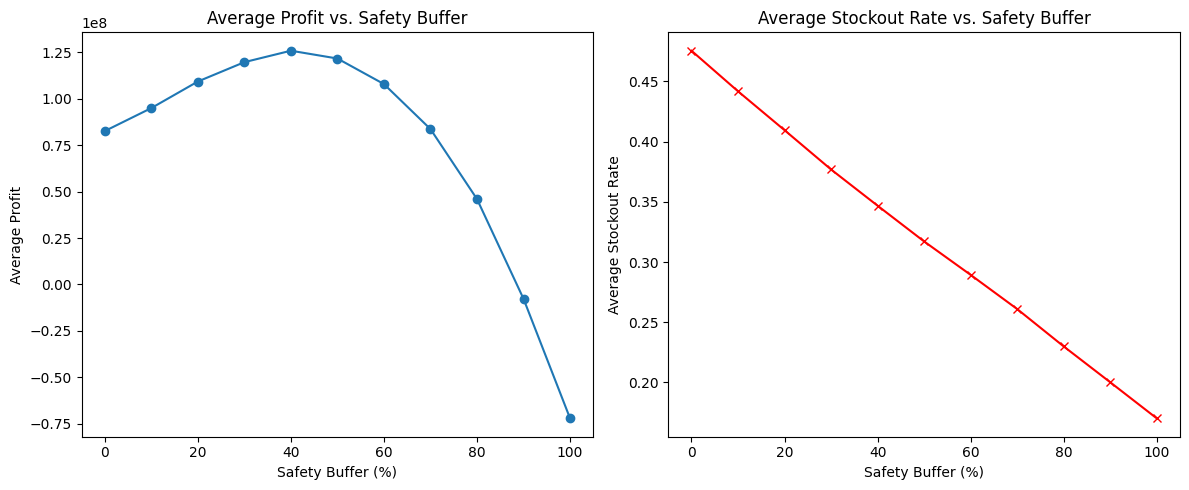

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['Safety_Buffer_%'], results_df['Avg_Profit'], marker='o')
plt.title("Average Profit vs. Safety Buffer")
plt.xlabel("Safety Buffer (%)")
plt.ylabel("Average Profit")

plt.subplot(1, 2, 2)
plt.plot(results_df['Safety_Buffer_%'], results_df['Avg_Stockout_Rate'], marker='x', color='red')
plt.title("Average Stockout Rate vs. Safety Buffer")
plt.xlabel("Safety Buffer (%)")
plt.ylabel("Average Stockout Rate")

plt.tight_layout()
plt.show()


### Further Inventory Optimization

In [20]:
import pandas as pd
import numpy as np

# --- Preprocessing ---
predictions_df = pd.read_csv("data/predictions.csv")
predictions_df.rename(columns={"Weekly_Sales": "Predicted_Weekly_Sales"}, inplace=True)

# Assign random unit cost for each Store–Dept pair
store_depts = predictions_df[['Store', 'Dept']].drop_duplicates()
store_depts['Unit_Cost'] = np.random.randint(100, 501, size=len(store_depts))
predictions_df = predictions_df.merge(store_depts, on=['Store', 'Dept'], how='left')

# Convert sales to units
predictions_df['Predicted_Units'] = predictions_df['Predicted_Weekly_Sales'] // predictions_df['Unit_Cost']
predictions_df['Unit_Selling_Price'] = predictions_df['Unit_Cost'] * 1.4
predictions_df['Unit_Holding_Cost'] = predictions_df['Unit_Cost'] * 0.35
predictions_df['Unit_Stockout_Cost'] = (
    (predictions_df['Unit_Selling_Price'] - predictions_df['Unit_Cost']) + 
    0.5 * predictions_df['Unit_Cost']
)

# --- Rolling std deviation of predicted sales ---
predictions_df['Rolling_Std'] = (
    predictions_df.groupby(['Store', 'Dept'])['Predicted_Weekly_Sales']
    .transform(lambda x: x.rolling(window=4, min_periods=1).std())
)

# Compute percentiles
low_thresh = predictions_df['Rolling_Std'].quantile(0.3)
high_thresh = predictions_df['Rolling_Std'].quantile(0.7)

# --- Assign Safety Buffer % based on volatility ---
def assign_buffer(std_val, idx):
    if idx < 4:
        return 40
    elif std_val < low_thresh:
        return 35
    elif std_val > high_thresh:
        return 45
    else:
        return 40

buffer_list = []
for _, group in predictions_df.groupby(['Store', 'Dept']):
    group = group.reset_index()
    buffer_vals = [
        assign_buffer(std_val, i) for i, std_val in enumerate(group['Rolling_Std'])
    ]
    buffer_list.append(pd.Series(buffer_vals, index=group['index']))

predictions_df['Safety_Buffer_%'] = pd.concat(buffer_list).sort_index()
# print(predictions_df)

# --- Simulation ---
all_profits = []
all_stockouts = []

for sim in range(5):  # Number of simulations
    def simulate(group):
        group = group.reset_index(drop=True)
        n = len(group)

        curr_inv = group.loc[0, 'Predicted_Units'] + 10
        order_qty = 0

        profit_list = []
        stockout_list = []

        for i in range(n):
            row = group.loc[i]
            buffer_fraction = row['Safety_Buffer_%'] / 100

            # Simulate actual sales
            actual_sales = np.random.normal(row['Predicted_Weekly_Sales'], scale=3000)
            actual_sales = max(0, actual_sales)
            actual_units = int(actual_sales // row['Unit_Cost'])

            # Predict next week demand
            if i + 1 < n:
                pred_next = group.loc[i + 1, 'Predicted_Units']
            else:
                pred_next = row['Predicted_Units']

            # Order quantity
            buffer_qty = buffer_fraction * pred_next
            next_order_qty = max(0, pred_next + buffer_qty - (curr_inv - row['Predicted_Units']))

            # Profit calculation
            revenue = actual_units * row['Unit_Selling_Price']
            cost = order_qty * row['Unit_Cost']
            holding_cost = max(0, curr_inv - actual_units) * row['Unit_Holding_Cost']
            stockout_cost = max(0, actual_units - curr_inv) * row['Unit_Stockout_Cost']
            profit = revenue - cost - holding_cost - stockout_cost

            profit_list.append(profit)
            stockout_list.append(actual_units > curr_inv)

            # Inventory update
            curr_inv = max(0, curr_inv + order_qty - actual_units)
            order_qty = next_order_qty

        return pd.Series({
            'Total_Profit': sum(profit_list),
            'Stockout_Rate': np.mean(stockout_list)
        })

    sim_results = predictions_df.groupby(['Store', 'Dept'], group_keys=False).apply(simulate, include_groups=False)
    all_profits.append(sim_results['Total_Profit'].sum())
    all_stockouts.append(sim_results['Stockout_Rate'].mean())

# --- Results ---
print(f"✅ Average Profit over 5 simulations: ₹{np.mean(all_profits):,.2f}")
print(f"📉 Average Stockout Rate: {np.mean(all_stockouts):.2%}")


✅ Average Profit over 5 simulations: ₹131,387,973.98
📉 Average Stockout Rate: 34.43%


In [21]:
(1.314-1.258)/1.258

0.04451510333863279